<a href="https://colab.research.google.com/github/MahfuzAhmed28/Glaucoma_detection_customized_cbam/blob/main/WithCustomizedCBAM.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import numpy as np
import os
import cv2
import matplotlib.pyplot as plt
from tensorflow.keras.applications.resnet50 import preprocess_input
from tensorflow.keras.preprocessing import image
import shutil
import random
from tqdm import tqdm


In [ ]:
data = r"/content/drive/MyDrive/Dataset/ACRIMA/PARTITIONED"  # Destination folder

In [ ]:
import os
import cv2
import numpy as np
import random
from tqdm import tqdm
from tensorflow.keras.layers import RandomFlip, RandomRotation, RandomContrast, RandomTranslation
from tensorflow.keras.models import Sequential
from sklearn.utils import shuffle

# Set seed for reproducibility
random.seed(1)
np.random.seed(1)

# Define dataset path and categories
DATADIR = r"/content/drive/MyDrive/Dataset/ACRIMA/PARTITIONED/Training"
CATEGORIES = ["normal", "glaucoma"]

IMG_SIZE = 256
training_data = []

# Function to create training dataset
def create_training_data():
    for category in CATEGORIES:
        path = os.path.join(DATADIR, category)
        class_num = CATEGORIES.index(category)

        for img in tqdm(os.listdir(path)):
            try:
                img_array = cv2.imread(os.path.join(path, img), cv2.IMREAD_COLOR)  # Read image
                if img_array is None:
                    continue  # Skip if image is not read
                new_array = cv2.resize(img_array, (IMG_SIZE, IMG_SIZE))  # Resize image
                training_data.append([new_array, class_num])
            except Exception as e:
                print(f"Error loading {img}: {e}")

# Run dataset creation
create_training_data()

# Shuffle the dataset
training_data = shuffle(training_data, random_state=1)

# Data Augmentation Pipeline
data_augmentation = Sequential([
    RandomFlip(mode="horizontal_and_vertical", seed=1),
    RandomRotation(factor=0.1, seed=1),  # ±10 degrees
    RandomContrast(factor=0.1, seed=1),
    RandomTranslation(height_factor=0.15, width_factor=0.15, fill_mode='wrap', seed=1)
])
'''
# Function for Histogram Equalization
def he(img):
    ycrcb = cv2.cvtColor(img, cv2.COLOR_BGR2YCrCb)  # Convert to YCrCb
    y, cr, cb = cv2.split(ycrcb)  # Split channels
    y_eq = cv2.equalizeHist(y)  # Apply histogram equalization on Y channel
    merged = cv2.merge((y_eq, cr, cb))  # Merge channels back
    return cv2.cvtColor(merged, cv2.COLOR_YCrCb2BGR)  # Convert back to BGR
'''
# Function for CLAHE (Contrast Limited Adaptive Histogram Equalization)
def clahe(img):
    lab = cv2.cvtColor(img, cv2.COLOR_BGR2LAB)  # Convert to LAB
    l, a, b = cv2.split(lab)  # Split channels
    clahe = cv2.createCLAHE(clipLimit=3.5, tileGridSize=(8, 8))  # Define CLAHE
    l_clahe = clahe.apply(l)  # Apply CLAHE to L channel
    merged = cv2.merge((l_clahe, a, b))  # Merge LAB channels back
    return cv2.cvtColor(merged, cv2.COLOR_LAB2BGR)  # Convert back to BGR

# Apply Preprocessing
X = []
y = []

for features, label in training_data:
    features = clahe(features)  # Apply CLAHE
    X.append(features)
    y.append(label)

# Convert to NumPy arrays
X = np.array(X).reshape(-1, IMG_SIZE, IMG_SIZE, 3)
y = np.array(y)

print(f"Dataset loaded: {X.shape}, Labels: {y.shape}")

100%|██████████| 318/318 [00:06<00:00, 46.67it/s]


Dataset loaded: (564, 256, 256, 3), Labels: (564,)


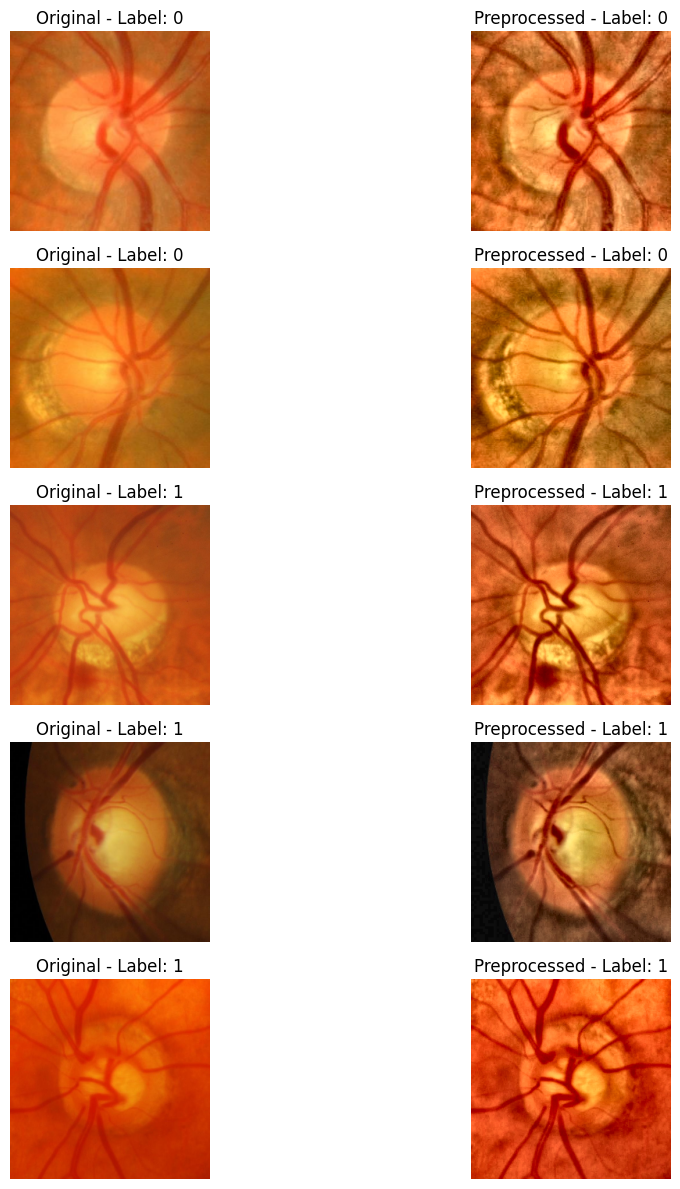

In [ ]:
import matplotlib.pyplot as plt

# Number of images to display
num_images = 5

plt.figure(figsize=(12, 12))

for i in range(num_images):
    original_img = training_data[i][0]  # Get original image before preprocessing
    preprocessed_img = X[i]  # Get preprocessed image

    # Convert BGR to RGB for proper display
    original_img_rgb = cv2.cvtColor(original_img, cv2.COLOR_BGR2RGB)
    preprocessed_img_rgb = cv2.cvtColor(preprocessed_img, cv2.COLOR_BGR2RGB)

    # Display original image
    plt.subplot(num_images, 2, 2 * i + 1)
    plt.imshow(original_img_rgb)
    plt.axis("off")
    plt.title(f"Original - Label: {y[i]}")

    # Display preprocessed image
    plt.subplot(num_images, 2, 2 * i + 2)
    plt.imshow(preprocessed_img_rgb)
    plt.axis("off")
    plt.title(f"Preprocessed - Label: {y[i]}")

plt.tight_layout()
plt.show()

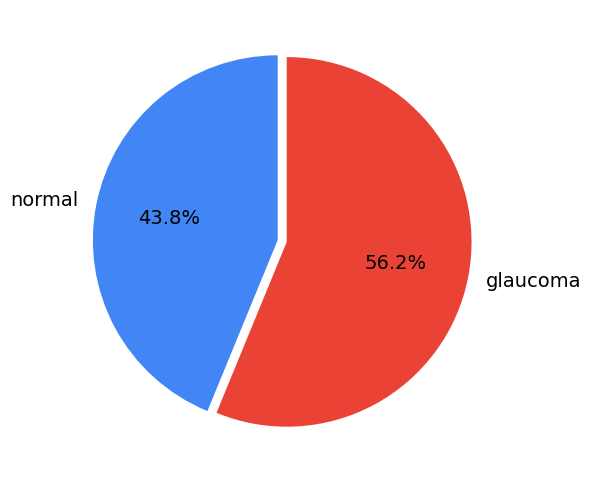

In [ ]:
# plotting training dataset
plt.figure(figsize=(14,6))
colors = ['#4285f4', '#ea4335']
plt.rcParams.update({'font.size': 14})
plt.pie([list(y).count(0), list(y).count(1)],
        labels=CATEGORIES,
        colors=colors, autopct='%.1f%%', explode=(0.025,0.025),
        startangle=90);

In [ ]:
import tensorflow as tf
from tensorflow.keras.layers import Layer, Conv2D, GlobalAveragePooling2D, GlobalMaxPooling2D, Reshape, Dense, multiply, Add, Activation, Concatenate
from tensorflow.keras import backend as K
from tensorflow.keras.utils import register_keras_serializable

@register_keras_serializable()
class CBAM(Layer):
    def __init__(self, filters, ratio=8, **kwargs):
        super(CBAM, self).__init__(**kwargs)
        self.filters = filters
        self.ratio = ratio

    def build(self, input_shape):
        self.shared_dense_one = Dense(self.filters // self.ratio,
                                      activation='relu',
                                      kernel_initializer='he_normal',
                                      use_bias=True)
        self.shared_dense_two = Dense(self.filters,
                                      kernel_initializer='he_normal',
                                      use_bias=True)
        self.spatial_conv = Conv2D(filters=1,
                                   kernel_size=7,
                                   strides=1,
                                   padding='same',
                                   activation='sigmoid',
                                   kernel_initializer='he_normal',
                                   use_bias=False)

    def call(self, inputs):
        # Channel Attention
        avg_pool = GlobalAveragePooling2D()(inputs)
        avg_pool = Reshape((1, 1, self.filters))(avg_pool)
        avg_pool = self.shared_dense_one(avg_pool)
        avg_pool = self.shared_dense_two(avg_pool)

        max_pool = GlobalMaxPooling2D()(inputs)
        max_pool = Reshape((1, 1, self.filters))(max_pool)
        max_pool = self.shared_dense_one(max_pool)
        max_pool = self.shared_dense_two(max_pool)

        channel_attention = Activation('sigmoid')(Add()([avg_pool, max_pool]))
        x = multiply([inputs, channel_attention])

        # Spatial Attention
        avg_pool = tf.reduce_mean(x, axis=-1, keepdims=True)
        max_pool = tf.reduce_max(x, axis=-1, keepdims=True)
        std_pool = tf.math.sqrt(tf.math.reduce_variance(x, axis=-1, keepdims=True) + 1e-6)
        concat = Concatenate(axis=-1)([avg_pool, max_pool,std_pool])
        spatial_attention = self.spatial_conv(concat)
        refined = multiply([x, spatial_attention])

        return refined

    def get_config(self):
        config = super(CBAM, self).get_config()
        config.update({
            'filters': self.filters,
            'ratio': self.ratio
        })
        return config


In [ ]:
from tensorflow.keras.applications import ResNet50,EfficientNetB0
from tensorflow.keras.layers import Input, GlobalAveragePooling2D, Dense, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam

IMG_SIZE = 256

input_tensor = Input(shape=(IMG_SIZE, IMG_SIZE, 3))
base_model = EfficientNetB0(include_top=False, weights='imagenet', input_tensor=input_tensor)
x = base_model.output

# Apply CBAM block
x = CBAM(filters=x.shape[-1])(x)

x = GlobalAveragePooling2D()(x)
x = Dropout(0.5)(x)
x = Dense(256, activation='relu')(x)
output = Dense(2, activation='softmax')(x)

model = Model(inputs=input_tensor, outputs=output)

model.compile(optimizer=Adam(1e-4), loss='sparse_categorical_crossentropy', metrics=['accuracy'])
model.summary()


Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_1       │ (None, 256, 256,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ rescaling_2         │ (None, 256, 256,  │          0 │ input_layer_1[0]… │
│ (Rescaling)         │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ normalization_1     │ (None, 256, 256,  │          7 │ rescaling_2[0][0] │
│ (Normalization)     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ rescaling_3         │ (None, 256, 256,  │          0 │ normalization_1[… │
│ (Rescaling)         │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_conv_pad       │ (None, 257, 257,  │          0 │ rescaling_3[0][0] │
│ (ZeroPadding2D)     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_conv (Conv2D)  │ (None, 128, 128,  │        864 │ stem_conv_pad[0]… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_bn             │ (None, 128, 128,  │        128 │ stem_conv[0][0]   │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_activation     │ (None, 128, 128,  │          0 │ stem_bn[0][0]     │
│ (Activation)        │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_dwconv      │ (None, 128, 128,  │        288 │ stem_activation[… │
│ (DepthwiseConv2D)   │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_bn          │ (None, 128, 128,  │        128 │ block1a_dwconv[0… │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_activation  │ (None, 128, 128,  │          0 │ block1a_bn[0][0]  │
│ (Activation)        │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_squeeze  │ (None, 32)        │          0 │ block1a_activati… │
│ (GlobalAveragePool… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_reshape  │ (None, 1, 1, 32)  │          0 │ block1a_se_squee… │
│ (Reshape)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_reduce   │ (None, 1, 1, 8)   │        264 │ block1a_se_resha… │
│ (Conv2D)            │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_expand   │ (None, 1, 1, 32)  │        288 │ block1a_se_reduc… │
│ (Conv2D)            │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_excite   │ (None, 128, 128,  │          0 │ block1a_activati… │
│ (Multiply)          │ 32)               │            │ block1a_se_expan… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_project_co… │ (None, 128, 128,  │        512 │ block1a_se_excit

 Total params: 4,789,208 (18.27 MB)

 Trainable params: 4,747,185 (18.11 MB)

 Non-trainable params: 42,023 (164.16 KB)

In [ ]:
from tensorflow.keras.callbacks import EarlyStopping

# training the model
batch_size = 32
epochs = 30
early_stop = EarlyStopping(monitor="val_loss", patience=3, restore_best_weights=True)
#history = model.fit(X, y, batch_size=batch_size, epochs=epochs, validation_split=0.15,callbacks=[early_stop])  # Stop early if no improvement
history = model.fit(X, y, batch_size=batch_size, epochs=10, validation_split=0.15)
'''
history = model.fit(
    train_generator,
    validation_data=val_generator,
    epochs=40,  # Start with a high number
    callbacks=[early_stop]  # Stop early if no improvement
)
'''

Epoch 1/10
15/15 ━━━━━━━━━━━━━━━━━━━━ 245s 13s/step - accuracy: 0.5725 - loss: 0.6884 - val_accuracy: 0.6118 - val_loss: 0.6563
Epoch 2/10
15/15 ━━━━━━━━━━━━━━━━━━━━ 205s 14s/step - accuracy: 0.8986 - loss: 0.4965 - val_accuracy: 0.6588 - val_loss: 0.6037
Epoch 3/10
15/15 ━━━━━━━━━━━━━━━━━━━━ 251s 13s/step - accuracy: 0.9661 - loss: 0.2909 - val_accuracy: 0.7059 - val_loss: 0.5280
Epoch 4/10
15/15 ━━━━━━━━━━━━━━━━━━━━ 193s 13s/step - accuracy: 0.9782 - loss: 0.1289 - val_accuracy: 0.7647 - val_loss: 0.4343
Epoch 5/10
15/15 ━━━━━━━━━━━━━━━━━━━━ 209s 14s/step - accuracy: 0.9887 - loss: 0.0603 - val_accuracy: 0.8824 - val_loss: 0.3308
Epoch 6/10
15/15 ━━━━━━━━━━━━━━━━━━━━ 189s 13s/step - accuracy: 0.9923 - loss: 0.0379 - val_accuracy: 0.9294 - val_loss: 0.2537
Epoch 7/10
15/15 ━━━━━━━━━━━━━━━━━━━━ 195s 13s/step - accuracy: 0.9872 - loss: 0.0311 - val_accuracy: 0.9529 - val_loss: 0.1878
Epoch 8/10
15/15 ━━━━━━━━━━━━━━━━━━━━ 213s 14s/step - accuracy: 0.9897 - loss: 0.0250 - val_accuracy: 0.

'\nhistory = model.fit(\n    train_generator,\n    validation_data=val_generator,\n    epochs=40,  # Start with a high number\n    callbacks=[early_stop]  # Stop early if no improvement\n)\n'

In [ ]:
train_acc = history.history['accuracy'][-1]
val_acc = history.history['val_accuracy'][-1]

print(f"Final Training Accuracy: {train_acc:.4f}")
print(f"Final Validation Accuracy: {val_acc:.4f}")

Final Training Accuracy: 0.9958
Final Validation Accuracy: 0.9882


In [ ]:
model.save("resnet50_model1.h5")
print("Model saved successfully.")

Model saved successfully.


In [ ]:
# Define test dataset path
TEST_DIR = r"/content/drive/MyDrive/Dataset/ACRIMA/PARTITIONED/Testing"

test_data = []
IMG_SIZE = 256
CATEGORIES = ["normal", "glaucoma"]

# Load and preprocess test data
for category in CATEGORIES:
    path = os.path.join(TEST_DIR, category)
    class_num = CATEGORIES.index(category)

    for img in os.listdir(path):
        try:
            img_array = cv2.imread(os.path.join(path, img), cv2.IMREAD_COLOR)
            if img_array is None:
                continue
            img_resized = cv2.resize(img_array, (IMG_SIZE, IMG_SIZE))  # Resize image
            img_preprocessed = clahe(img_resized)  # Apply same preprocessing as training data
            test_data.append([img_preprocessed, class_num])
        except Exception as e:
            print(f"Error loading {img}: {e}")

# Shuffle and convert test data to arrays
test_data = shuffle(test_data, random_state=1)
X_test = np.array([i[0] for i in test_data]).reshape(-1, IMG_SIZE, IMG_SIZE, 3)
y_test = np.array([i[1] for i in test_data])

In [ ]:
from tensorflow.keras.models import load_model

model = load_model("resnet50_model1.h5", custom_objects={'CBAM': CBAM})

In [ ]:
test_loss, test_acc = model.evaluate(X_test, y_test, verbose=1)
print(f"Test Accuracy: {test_acc:.4f}")
print(f"Test Loss: {test_loss:.4f}")

5/5 ━━━━━━━━━━━━━━━━━━━━ 20s 3s/step - accuracy: 0.9868 - loss: 0.0635
Test Accuracy: 0.9929
Test Loss: 0.0385


5/5 ━━━━━━━━━━━━━━━━━━━━ 18s 3s/step
Classification Report:

             precision  recall f1-score support
normal          1.0000  0.9839   0.9919      62
glaucoma        0.9875  1.0000   0.9937      79
accuracy        0.9929  0.9929   0.9929       0
macro avg       0.9938  0.9919   0.9928     141
weighted avg    0.9930  0.9929   0.9929     141


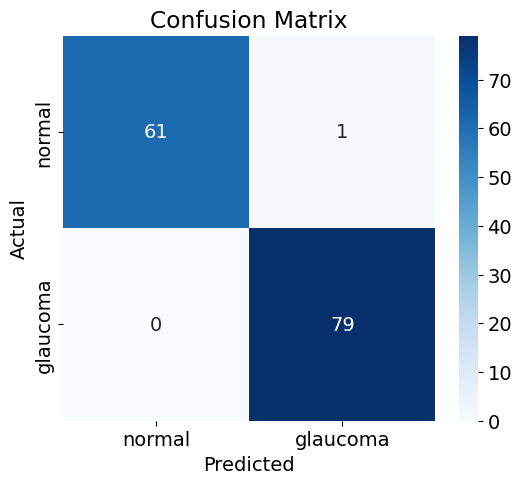

Cohen's Kappa Score: 0.9856
Multi-class AUC Score: 0.9996


In [ ]:
# from sklearn.metrics import classification_report, confusion_matrix
# import seaborn as sns
# import matplotlib.pyplot as plt

# y_pred = model.predict(X_test)
# y_pred_classes = np.argmax(y_pred, axis=1)  # Convert probabilities to class labels

# print(classification_report(y_test, y_pred_classes, target_names=CATEGORIES))

# # Plot confusion matrix
# cm = confusion_matrix(y_test, y_pred_classes)
# plt.figure(figsize=(6, 5))
# sns.heatmap(cm, annot=True, cmap="Blues", fmt="d", xticklabels=CATEGORIES, yticklabels=CATEGORIES)
# plt.xlabel("Predicted")
# plt.ylabel("Actual")
# plt.title("Confusion Matrix")
# plt.show()

from sklearn.metrics import (
    classification_report,
    confusion_matrix,
    cohen_kappa_score,
    roc_auc_score
)
from sklearn.preprocessing import label_binarize
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

# Make predictions
y_pred = model.predict(X_test)

# Convert probabilities to class labels
y_pred_classes = np.argmax(y_pred, axis=1)

# === Classification Report with 4 decimal places ===
report_dict = classification_report(
    y_test, y_pred_classes, target_names=CATEGORIES, output_dict=True
)
report_df = pd.DataFrame(report_dict).transpose()

for metric in ['precision', 'recall', 'f1-score']:
    report_df[metric] = report_df[metric].apply(lambda x: f"{x:.4f}" if isinstance(x, (int, float)) else x)

report_df['support'] = report_df['support'].apply(lambda x: f"{int(x)}" if isinstance(x, (int, float)) else x)

print("Classification Report:\n")
print(report_df[['precision', 'recall', 'f1-score', 'support']])

# === Confusion Matrix ===
cm = confusion_matrix(y_test, y_pred_classes)
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, cmap="Blues", fmt="d",
            xticklabels=CATEGORIES, yticklabels=CATEGORIES)
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()

# === Compute Cohen's Kappa ===
kappa = cohen_kappa_score(y_test, y_pred_classes)
print(f"Cohen's Kappa Score: {kappa:.4f}")

# === Compute AUC ===
if len(CATEGORIES) == 2:
    # Binary classification
    auc = roc_auc_score(y_test, y_pred[:, 1])
else:
    # Multi-class classification
    y_test_bin = label_binarize(y_test, classes=range(len(CATEGORIES)))
    auc = roc_auc_score(y_test_bin, y_pred, average="macro", multi_class="ovr")

print(f"Multi-class AUC Score: {auc:.4f}")



In [ ]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import cv2
from tensorflow.keras.models import Model

def make_gradcam_heatmap(img_array, model, last_conv_layer_name, pred_index=None):
    grad_model = Model(
    inputs=model.input,
    outputs=[model.get_layer(last_conv_layer_name).output, model.output]
)


    with tf.GradientTape() as tape:
        conv_outputs, predictions = grad_model(img_array)
        if pred_index is None:
            pred_index = tf.argmax(predictions[0])
        class_output = predictions[:, pred_index]

    # Compute gradients
    grads = tape.gradient(class_output, conv_outputs)
    pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))

    conv_outputs = conv_outputs[0]
    heatmap = conv_outputs @ pooled_grads[..., tf.newaxis]
    heatmap = tf.squeeze(heatmap)

    heatmap = tf.maximum(heatmap, 0) / tf.math.reduce_max(heatmap)
    return heatmap.numpy()

def save_and_display_gradcam(img_bgr, heatmap, alpha=0.5):
    img_bgr = cv2.resize(img_bgr, (256, 256))
    img_rgb = cv2.cvtColor(img_bgr, cv2.COLOR_BGR2RGB)

    heatmap = np.uint8(255 * heatmap)
    jet = cv2.applyColorMap(heatmap, cv2.COLORMAP_JET)
    jet = cv2.resize(jet, (img_rgb.shape[1], img_rgb.shape[0]))

    superimposed_img = cv2.addWeighted(jet, alpha, img_rgb, 1 - alpha, 0)

    plt.figure(figsize=(6, 3))
    plt.subplot(1, 2, 1)
    plt.imshow(img_rgb)
    plt.title("Original")
    plt.axis("off")

    plt.subplot(1, 2, 2)
    plt.imshow(superimposed_img)
    plt.title("Grad-CAM")
    plt.axis("off")

    plt.tight_layout()
    plt.show()
